- Intro
- Acquire
- Prepare
- Univariate Explore
- Split
- Explore/Stats
- Kmeans, binning, feature engineering
    combining features:
    - rooms (bed, bath) - ratio in one col?
    - size (square, lot, garage)
    - extras (pool, garage)
    - year
    - location & (code)
- Additional explore/stats
- takeaways about log error drivers
- modeling pre (different codes)
- modeling
- model summary
- conclusion

### INTRO

### IMPORTS/ACQUIRE

In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans2, whiten

np.random.seed(12)

In [2]:
df = acquire.get_zillow_data()
df = prepare.remove_outliers(df)
df = prepare.handle_nulls(df)
df = prepare.rename_columns(df)
df = prepare.prepare_locs(df)

### note: add to prepare...

In [3]:
df = df[(df.propertycountylandusecode == '0100') | (df.propertycountylandusecode == '122') | (df.propertycountylandusecode == '0101') | (df.propertycountylandusecode == '1111') | (df.propertycountylandusecode == '1') | (df.propertycountylandusecode == '1110') | (df.propertycountylandusecode == '0104')]

### note : talk about % of data still here, what was dropped, why, handling nulls and outliers

### SPLIT
### note: make in function

In [4]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting

**Number of Train Records:** 26,727

**Number of Validate Records:** 11,455

**Number of Test Records:** 9,546

### EXPLORE

- Ask questions
- what is driving logerror?
- hypothesize homes that don't quite fit normal patterns(take drivers from tax value into account) - ie. older home that has a very high value and/or square feet, very small home with high value, strange ratio of bed to bath
- does location impact error (are some locations harder to predict?)

### STATS

### Feature Eng

In [5]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [6]:
X = train[['bedrooms', 'bathrooms']]
XVAL = validate[['bedrooms', 'bathrooms']]
XTEST = test[['bedrooms', 'bathrooms']]

kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

kmeans.predict(X)

train['room_cluster'] = kmeans.predict(X)
validate['room_cluster'] = kmeans.predict(XVAL)
test['room_cluster'] = kmeans.predict(XTEST)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,bedrooms,bathrooms
0,4.043519,2.076041
1,2.286465,1.240587
2,4.233365,3.030203
3,2.987774,2.050923
4,4.442680,4.303522
5,2.929577,3.114493


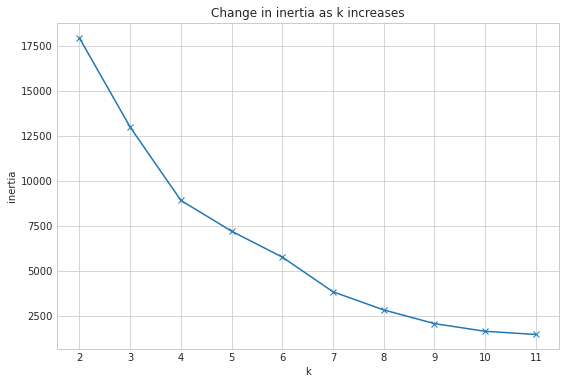

In [7]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [8]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train[['square_feet', 'lot_size']])
train_s = (train[['square_feet', 'lot_size']])
X = scaler.transform(train[['square_feet', 'lot_size']])
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)

In [9]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

train['size_cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,square_feet,lot_size
0,0.323972,0.003452
1,0.096020,0.002263
2,0.199263,0.002746
3,0.479487,0.004862
4,0.698287,0.006645


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26727 entries, 34946 to 15514
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   26727 non-null  int64         
 1   bathrooms                  26727 non-null  float64       
 2   bedrooms                   26727 non-null  float64       
 3   square_feet                26727 non-null  int64         
 4   fips                       26727 non-null  int64         
 5   garages                    26727 non-null  int64         
 6   garage_size                26727 non-null  int64         
 7   lot_size                   26727 non-null  int64         
 8   has_pool                   26727 non-null  bool          
 9   propertycountylandusecode  26727 non-null  object        
 10  propertylandusetypeid      26727 non-null  float64       
 11  year_built                 26727 non-null  int64         
 12  

In [176]:
num_vars = train[['lot_size', 'square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .1, min_samples = 10).fit(X)
train['DB_lot']=clustering.labels_
train['DB_lot'].value_counts()

 1     6260
 5     2850
 2     2664
 0     2152
 3     1603
 4     1410
 7     1192
-1      912
 17     833
 6      686
 9      668
 13     644
 10     363
 14     222
 24     220
 15     201
 27     199
 12     193
 18     187
 28     178
 20     123
 30     101
 33      98
 11      92
 8       84
 22      84
 21      78
 23      77
 19      77
 16      76
 26      71
 40      70
 25      70
 35      68
 37      68
 36      67
 39      63
 38      60
 34      45
 29      40
 43      40
 47      32
 32      32
 49      26
 45      26
 50      21
 42      20
 46      18
 48      16
 41      14
 44      14
 53      12
 51      11
 31      10
 52      10
 56      10
 54       8
 55       5
Name: DB_lot, dtype: int64

In [169]:
tryit = train[train['DB_lot'] == -1]

In [175]:
tryit.bathrooms.value_counts()

4.0    831
3.0    765
2.0    457
3.5    345
5.0    286
4.5    253
2.5    214
1.0    209
1.5     86
Name: bathrooms, dtype: int64

In [163]:
train.log_error_binn.value_counts()

P1    16692
P2     8782
Name: log_error_binn, dtype: int64

In [13]:
num_vars = train[['lot_size', 'bedrooms', 'bathrooms', 'latitude', 'longitude']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .04, min_samples = 50).fit(X)
train['DB_lot1']=clustering.labels_
train['DB_lot1'].value_counts()

-1     6220
 1     6167
 0     2077
 2     1722
 3     1594
 5     1204
 11     857
 6      697
 16     625
 12     612
 8      560
 13     548
 7      529
 19     357
 18     220
 21     201
 24     188
 10     183
 26     162
 9      158
 14     152
 17     149
 25     148
 23     135
 27     120
 20     112
 34     109
 28     103
 15     100
 4       95
 22      67
 31      66
 29      64
 35      58
 33      57
 32      55
 38      52
 36      51
 39      50
 30      50
 40      38
 37      15
Name: DB_lot1, dtype: int64

In [14]:
num_vars = train[['lot_size', 'bedrooms', 'bathrooms', 'latitude', 'longitude']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .15, min_samples = 50).fit(X)
train['DB_lot2']=clustering.labels_
train['DB_lot2'].value_counts()

 1    12446
 2     8059
 0     3843
 3     1756
-1      270
 5      112
 6      101
 4       91
 7       49
Name: DB_lot2, dtype: int64

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26727 entries, 34946 to 15514
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   26727 non-null  int64         
 1   bathrooms                  26727 non-null  float64       
 2   bedrooms                   26727 non-null  float64       
 3   square_feet                26727 non-null  int64         
 4   fips                       26727 non-null  int64         
 5   garages                    26727 non-null  int64         
 6   garage_size                26727 non-null  int64         
 7   lot_size                   26727 non-null  int64         
 8   has_pool                   26727 non-null  bool          
 9   propertycountylandusecode  26727 non-null  object        
 10  propertylandusetypeid      26727 non-null  float64       
 11  year_built                 26727 non-null  int64         
 12  

In [16]:
num_vars = train[['has_pool',  'garages', 'latitude', 'longitude']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .08, min_samples = 50).fit(X)
train['DB_extra']=clustering.labels_
train['DB_extra'].value_counts()
#'taxvaluedollarcnt',

 0    21285
 1     5147
 2      218
-1       77
Name: DB_extra, dtype: int64

In [17]:
num_vars = train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .12, min_samples = 50).fit(X)
train['DB_square']=clustering.labels_
train['DB_square'].value_counts()
#'taxvaluedollarcnt',

 1     7219
 2     3005
 4     2934
-1     2784
 0     2320
 3     1706
 9     1672
 6     1218
 11     851
 5      702
 17     371
 8      275
 7      266
 10     217
 13     204
 12     179
 23     123
 22     105
 18      95
 14      89
 21      80
 15      69
 19      67
 20      61
 16      58
 24      57
Name: DB_square, dtype: int64

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26727 entries, 34946 to 15514
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   26727 non-null  int64         
 1   bathrooms                  26727 non-null  float64       
 2   bedrooms                   26727 non-null  float64       
 3   square_feet                26727 non-null  int64         
 4   fips                       26727 non-null  int64         
 5   garages                    26727 non-null  int64         
 6   garage_size                26727 non-null  int64         
 7   lot_size                   26727 non-null  int64         
 8   has_pool                   26727 non-null  bool          
 9   propertycountylandusecode  26727 non-null  object        
 10  propertylandusetypeid      26727 non-null  float64       
 11  year_built                 26727 non-null  int64         
 12  

In [19]:
num_vars = train[['bathrooms', 'bedrooms', 'square_feet', 'taxvaluedollarcnt']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .12, min_samples = 50).fit(X)
train['DB_tax']=clustering.labels_
train['DB_tax'].value_counts()

 1     7221
 2     3002
 5     2933
 0     2419
 3     1847
 4     1719
-1     1394
 8     1314
 14    1028
 7      906
 6      767
 12     427
 10     292
 13     269
 19     236
 15     166
 16     130
 17     116
 21     111
 20     105
 9       93
 11      87
 18      84
 22      61
Name: DB_tax, dtype: int64

In [20]:
num_vars = train[['has_pool', 'bathrooms', 'year_built','latitude', 'longitude']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .12, min_samples = 50).fit(X)
train['DB_pool']=clustering.labels_
train['DB_pool'].value_counts()

 1     9674
 0     3984
 3     3868
-1     2130
 5     1914
 2     1686
 4     1402
 10     341
 13     326
 7      302
 11     204
 12     203
 9      114
 15     112
 8       86
 16      77
 6       75
 14      61
 17      59
 19      57
 18      52
Name: DB_pool, dtype: int64

In [21]:
num_vars = train[['taxvaluedollarcnt', 'square_feet', 'bedrooms', 'bathrooms', 'has_pool', 'garages']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .1, min_samples = 50).fit(X)
train['DB_tax']=clustering.labels_
train['DB_tax'].value_counts()

 1     5990
-1     3546
 2     2344
 0     2326
 5     1937
 3     1711
 10    1190
 9     1153
 7     1126
 13     889
 15     879
 6      642
 11     606
 16     465
 4      301
 17     240
 12     238
 24     130
 18     124
 14     117
 19     106
 23      93
 21      91
 22      89
 26      84
 8       75
 20      68
 25      67
 27      50
 28      50
Name: DB_tax, dtype: int64

In [22]:
num_vars = train[['year_built','taxvaluedollarcnt', 'square_feet', 'bedrooms', 'bathrooms', 'has_pool', 'garages']]
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
X = scaler.transform(num_vars)
X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
clustering = DBSCAN(eps = .12, min_samples = 50).fit(X)
train['DB_year']=clustering.labels_
train['DB_year'].value_counts()

 1     5911
-1     5104
 0     2303
 2     2301
 4     1816
 3     1694
 7     1118
 6     1095
 8     1043
 11     872
 13     819
 5      628
 9      578
 10     225
 15     223
 17     200
 14     175
 21     116
 12     105
 16      92
 18      87
 19      83
 20      81
 22      58
Name: DB_year, dtype: int64

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans2, whiten

In [24]:
p = .05

In [25]:
clustering = DBSCAN(eps = .1, min_samples = 50).fit(X)
train['DB_lot']=clustering.labels_
# kmeans = KMeans(n_clusters=5)
# kmeans_clusters = kmeans.fit_predict(X_scaled)



In [26]:
train['DB_lot'].value_counts()

-1     6708
 1     5833
 0     2252
 2     2169
 4     1706
 3     1668
 7     1040
 11     837
 8      767
 6      743
 5      607
 9      554
 14     487
 13     283
 10     212
 15     172
 18     160
 12      99
 16      99
 19      89
 20      71
 17      62
 21      59
 22      50
Name: DB_lot, dtype: int64

In [27]:
X = train[['square_feet', 'propertycountylandusecode', 'garages', 'has_pool']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

kmeans.predict(X)

train['extras_cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,square_feet,propertycountylandusecode,garages,has_pool
0,2152.872967,104.940734,0.708231,0.273164
1,1750.642100,1110.811771,1.882821,0.148993
2,3413.568341,215.055099,1.048402,0.447793
3,1288.514732,105.019494,0.400670,0.107887


In [28]:
plt.rcParams["figure.figsize"] = (15,8)

In [29]:
bins = [-.6, -.0475, -.0244, -.0106, 0, .0125, .0283, .0586, .6]
labels = ['N4','N3','N2','N1', 'P1', 'P2', 'P3', 'P4']
train['log_error_bin'] = pd.cut(train['log_error'], bins=bins, labels=labels)
validate['log_error_bin'] = pd.cut(validate['log_error'], bins=bins, labels=labels)
test['log_error_bin'] = pd.cut(test['log_error'], bins=bins, labels=labels)

<Figure size 648x432 with 0 Axes>

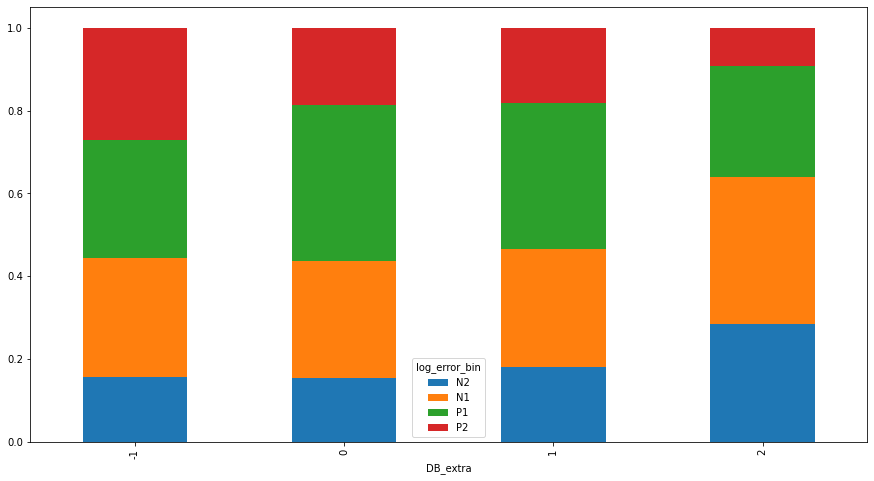

In [185]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['DB_extra'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

<Figure size 648x432 with 0 Axes>

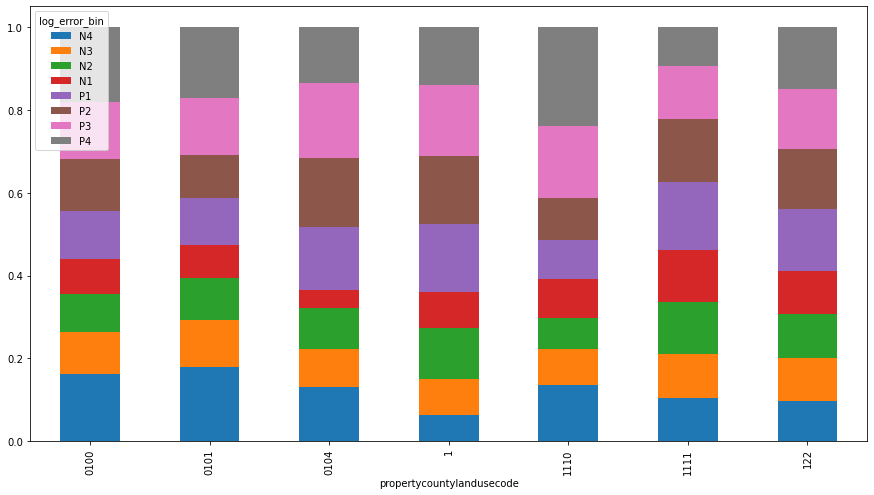

In [31]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['propertycountylandusecode'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

In [32]:
train_neg = train.where(train.log_error < 0)
train_pos = train.where(train.log_error > 0)
train_neg = train_neg.dropna()
train_pos = train_pos.dropna()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

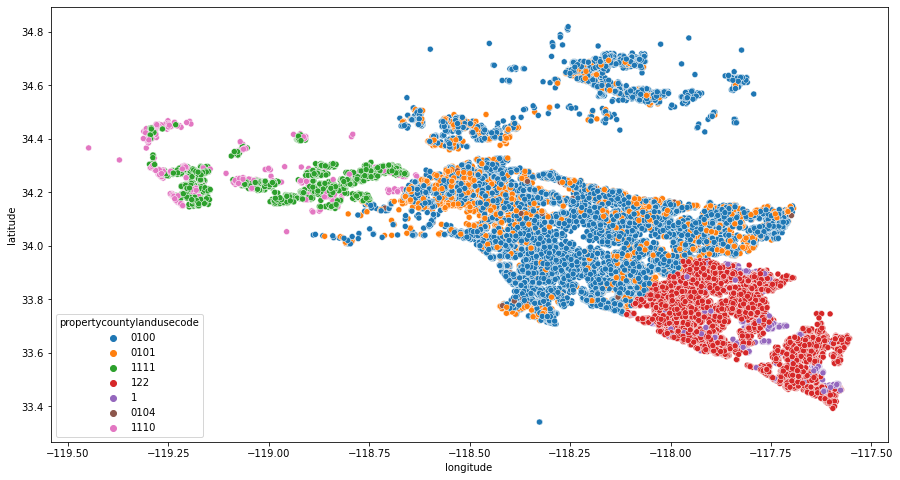

In [33]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='propertycountylandusecode')

In [34]:
bins = [0, 1214, 1497, 1850, 2430, 5600]
labels = [1,2,3,4,5]
train['square_feet_bin'] = pd.cut(train['square_feet'], bins=bins, labels=labels)
validate['square_feet_bin'] = pd.cut(validate['square_feet'], bins=bins, labels=labels)
test['square_feet_bin'] = pd.cut(test['square_feet'], bins=bins, labels=labels)

In [35]:
bins = [1900, 1930, 1950, 1970, 2000, 2020]
labels = labels = [1,2,3,4,5]
train['year_bin'] = pd.cut(train['year_built'], bins=bins, labels=labels)
validate['year_bin'] = pd.cut(train['year_built'], bins=bins, labels=labels)
test['year_bin'] = pd.cut(train['year_built'], bins=bins, labels=labels)

<Figure size 648x432 with 0 Axes>

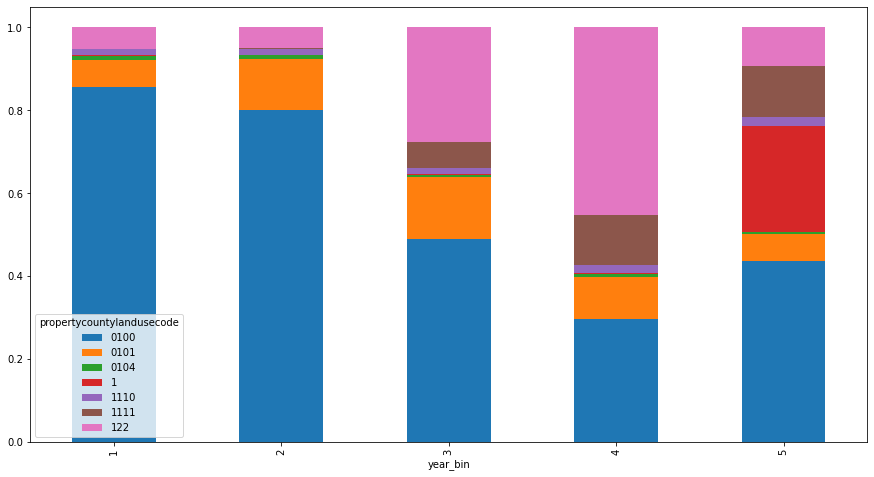

In [186]:
plt.figure(figsize=(9, 6))
pd.crosstab(train['year_bin'],train['propertycountylandusecode'], 
             normalize='index').plot.bar(stacked=True)
plt.show()

In [37]:
train['garages'] = train.garages.astype(bool)
train['has_pool'] = train.has_pool.astype(bool)

In [38]:
train['garages'] = train.garages.astype(int)
train['has_pool'] = train.has_pool.astype(int)

In [39]:
train['extras'] = train['garages'] + train['has_pool']

In [40]:
train.extras.value_counts()

0    13956
1    10718
2     2053
Name: extras, dtype: int64

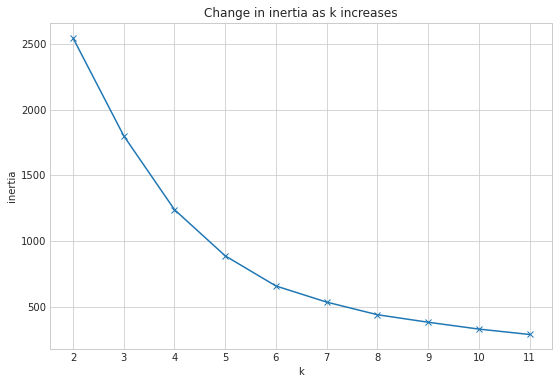

In [41]:
X = train[['latitude', 'longitude']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [42]:
X = train[['latitude', 'longitude']]
XV = validate[['latitude', 'longitude']]
XT = test[['latitude', 'longitude']]

kmeans = KMeans(n_clusters=20)
kmeans.fit(X)

kmeans.predict(X)

train['cluster_locs'] = kmeans.predict(X)
validate['cluster_locs'] = kmeans.predict(XV)
test['cluster_locs'] = kmeans.predict(XT)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,latitude,longitude
0,34.083649,-117.781544
1,34.037012,-118.412480
2,33.742325,-117.979853
3,34.224114,-118.858077
4,34.660740,-118.168729
5,33.565937,-117.659660
6,33.905245,-117.979764
7,34.101356,-118.103091
8,34.259032,-119.178504
9,33.818136,-118.343440


In [43]:
train.cluster_locs.head()

34946    12
52306    11
13996    18
41770    12
48530    13
Name: cluster_locs, dtype: int32

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

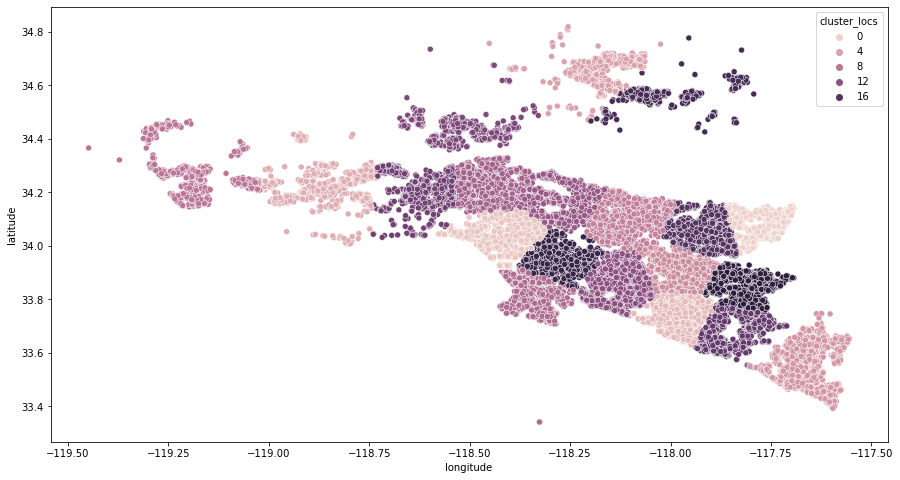

In [44]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster_locs')

In [45]:
bins = [500, 160726, 299498, 445086, 667000, 3000000]
labels = [1,2,3,4,5]
train['value_bin'] = pd.cut(train['taxvaluedollarcnt'], bins=bins, labels=labels)
validate['value_bin'] = pd.cut(train['taxvaluedollarcnt'], bins=bins, labels=labels)
test['value_bin'] = pd.cut(train['taxvaluedollarcnt'], bins=bins, labels=labels)

In [46]:
train.value_bin.value_counts()

2    5350
1    5346
4    5346
5    5345
3    5340
Name: value_bin, dtype: int64

In [47]:
bins = [0, 5272, 6299, 7368, 9518, 56700, 100000000]
labels = [1,2,3,4,5, 6]
train['lot_size_bin'] = pd.cut(train['lot_size'], bins=bins, labels=labels)
validate['lot_size_bin'] = pd.cut(validate['lot_size'], bins=bins, labels=labels)
test['lot_size_bin'] = pd.cut(test['lot_size'], bins=bins, labels=labels)

In [48]:
train.landtaxvaluedollarcnt.quantile(1)

2817215.0

In [49]:
bins = [0, 54240, 159758, 279118, 448013, 3817215]
labels = [1,2,3,4,5]
train['lot_value_bin'] = pd.cut(train['landtaxvaluedollarcnt'], bins=bins, labels=labels)
validate['lot_value_bin'] = pd.cut(validate['landtaxvaluedollarcnt'], bins=bins, labels=labels)
test['lot_value_bin'] = pd.cut(test['landtaxvaluedollarcnt'], bins=bins, labels=labels)

In [50]:
bins = [0, 1214, 1497, 1850, 2430, 5600]
labels = [1,2,3,4,5]
train['square_feet_bin'] = pd.cut(train['square_feet'], bins=bins, labels=labels)
validate['square_feet_bin'] = pd.cut(validate['square_feet'], bins=bins, labels=labels)
test['square_feet_bin'] = pd.cut(test['square_feet'], bins=bins, labels=labels)

In [51]:
bins = [0, 5272, 6299, 7368, 9518, 56700, 100000000]
labels = [1,2,3,4,5,6]
train['lot_size_bin'] = pd.cut(train['lot_size'], bins=bins, labels=labels)
validate['lot_size_bin'] = pd.cut(validate['lot_size'], bins=bins, labels=labels)
test['lot_size_bin'] = pd.cut(test['lot_size'], bins=bins, labels=labels)

In [52]:
train['lot_size_bin'] = train['lot_size_bin'].astype(int)
train['square_feet_bin'] = train['square_feet_bin'].astype(int)

In [53]:
train['add_size'] = train['lot_size'] + train['square_feet']

In [54]:
(train.log_error).where(train.add_size == 2).mean()

nan

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26727 entries, 34946 to 15514
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   26727 non-null  int64         
 1   bathrooms                  26727 non-null  float64       
 2   bedrooms                   26727 non-null  float64       
 3   square_feet                26727 non-null  int64         
 4   fips                       26727 non-null  int64         
 5   garages                    26727 non-null  int64         
 6   garage_size                26727 non-null  int64         
 7   lot_size                   26727 non-null  int64         
 8   has_pool                   26727 non-null  int64         
 9   propertycountylandusecode  26727 non-null  object        
 10  propertylandusetypeid      26727 non-null  float64       
 11  year_built                 26727 non-null  int64         
 12  

In [56]:
train['year_bin'] = train.year_bin.astype(int)

In [57]:
train['value_bin'] = train.value_bin.astype(int)

In [58]:
train['lot_value_bin'] = train.lot_value_bin.astype(int)

In [59]:
train['code'] = train.propertycountylandusecode.astype(int)

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26727 entries, 34946 to 15514
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   26727 non-null  int64         
 1   bathrooms                  26727 non-null  float64       
 2   bedrooms                   26727 non-null  float64       
 3   square_feet                26727 non-null  int64         
 4   fips                       26727 non-null  int64         
 5   garages                    26727 non-null  int64         
 6   garage_size                26727 non-null  int64         
 7   lot_size                   26727 non-null  int64         
 8   has_pool                   26727 non-null  int64         
 9   propertycountylandusecode  26727 non-null  object        
 10  propertylandusetypeid      26727 non-null  float64       
 11  year_built                 26727 non-null  int64         
 12  

In [61]:
train = train[train.log_error > -0.2]
train = train[train.log_error < 0.2]

In [62]:
bins = [-.2,  -.0410,  0, .0461,  .2]
labels = ['N2','N1', 'P1', 'P2']
train['log_error_bin'] = pd.cut(train['log_error'], bins=bins, labels=labels)
validate['log_error_bin'] = pd.cut(validate['log_error'], bins=bins, labels=labels)
test['log_error_bin'] = pd.cut(test['log_error'], bins=bins, labels=labels)

In [63]:
train_neg = train.where(train.log_error < 0).dropna()
train_pos = train.where(train.log_error > 0).dropna()

In [64]:
train_pos.log_error.mean()

0.04261955814973157

In [65]:
train['log_error_binn'] = train['log_error_bin'].replace(['N1'],'P1')

In [66]:
train['log_error_binn'] = train['log_error_binn'].replace(['N2'],'P2')

In [67]:
train['log_error_binn'].value_counts()

P1    16692
P2     8782
Name: log_error_binn, dtype: int64

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25474 entries, 34946 to 20675
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   25474 non-null  int64         
 1   bathrooms                  25474 non-null  float64       
 2   bedrooms                   25474 non-null  float64       
 3   square_feet                25474 non-null  int64         
 4   fips                       25474 non-null  int64         
 5   garages                    25474 non-null  int64         
 6   garage_size                25474 non-null  int64         
 7   lot_size                   25474 non-null  int64         
 8   has_pool                   25474 non-null  int64         
 9   propertycountylandusecode  25474 non-null  object        
 10  propertylandusetypeid      25474 non-null  float64       
 11  year_built                 25474 non-null  int64         
 12  

In [177]:
#X_train = train[['garages', 'has_pool', 'garage_size', 'taxvaluedollarcnt', 'propertycountylandusecode', 'landtaxvaluedollarcnt', 'extras_cluster', 'square_feet_bin', 'year_bin', 'DB_year', 'DB_pool', 'DB_square', 'DB_extra', 'DB_lot', 'lot_size_bin', 'lot_value_bin', 'value_bin', 'cluster_locs', 'code', 'square_feet', 'lot_size', 'year_built', 'extras',  'DB_lot', 'DB_lot1', 'DB_lot2', 'DB_tax']]
X_train = train[['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'DB_lot']]
                 #'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'square_feet']]
y_train = train.log_error_binn

#X_train = train[['garages', 'DB_lot', 'DB_square', 'DB_pool', 'DB_extra', 'DB_year', 'DB_tax', 'has_pool','year_built', 'taxvaluedollarcnt']]

In [69]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [180]:
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = DecisionTreeClassifier()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

rfe_feature

['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size']

In [183]:
clf = DecisionTreeClassifier(max_depth=15)
clf = clf.fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.77


In [72]:
train_neg = train.where(train.log_error < 0)
train_pos = train.where(train.log_error > 0)

In [73]:
train_neg= train_neg.dropna()
train_pos = train_pos.dropna()

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Log Error'}>

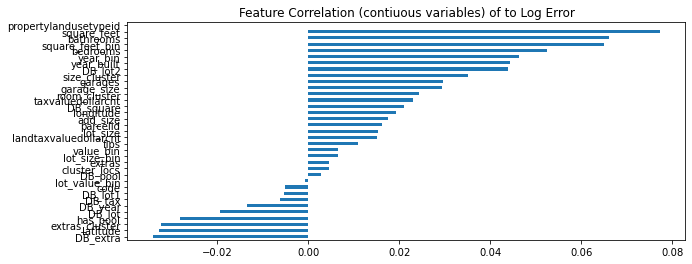

In [74]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Log Error")
corr_chart = train.drop(['log_error'], axis=1).corrwith(train['log_error']).sort_values().plot.barh()
corr_chart